# Active Aero Arduino Project Report

## NOTE: Other files in the repository are occasionally referred to in this report

### 0.1 Abstract and Objectives

In this project, a simple mechanical test rig was constructed consisting of a foam elevator, an actuator, and a cardboard base. Two separate Arduino sketches were developed to represent different operating modes of the same core control system.
<br>
The first sketch implemented a PID controller to drive a simulated aircraft pitch angle to a commanded target, analogous to an attitude-hold autopilot. Step-response testing was used to tune the controller gains. The second sketch responded to the measured physical orientation of a breadboard, mimicking the corrective elevator behaviour an aircraft would exhibit when attempting to maintain a zero-pitch attitude in the presence of disturbances such as turbulence.
<br>
The aircraft plant was modelled using semi-implicit Euler integration with a simplified pitch-rate damping term. The primary objective of the first operating mode was to minimise steady-state error while simultaneously limiting overshoot. While steady-state error was successfully reduced to within acceptable bounds, actuator quantisation, saturation, and discrete-time effects prevented complete elimination of residual error.




### 0.2 Extra system specifications and considerations
- Servo.h library used, limiting elevator angles to integers
- Adafruit MPU6050 library used for accelerometer
- The rate of calculations and actuator adjustments was successfully reduced to 200 Hz, primarily due to an observed actuator rate of ~ 350 $^\circ s^{-1}$
- Actuator limited to $\pm$ 35 $^\circ$ to analogous to mechanical limits in aircraft
-  Plant model uses estimated deflection, u, based on actuator rate limit, rather than commanded angle to calculate pitch acceleration. The simplified model used was exactly as follows: $$\ddot{\theta} = au - b\dot{\theta} $$
This was chosen to show the effects of the pitching moment, induced by the elevators, and damping on the angular acceleration of an aircraft.



## 0.3 Control Architecture, Tuning, and Results

For the PID controller, error was defined as target pitch - current pitch. The frequency of updates was chosen as 200 Hz in line with the other discrete-time components of the system. The controller started out by adding P $\rightarrow$ D $\rightarrow$ I progressively to reduce overshoot and steady-state error. The proportional component represents the elevator deflection commanded per unit error. Similarly, the integral and derivative components represent the commanded deflection per unit cumulative error and rate of change of error respectively. Tuning was primarily done using step-response testing, adjusting the values of the constants K_p, K_i and K_d to minimise steady-state error to below 1% and, simultaneously, overshoot in simulated pitch. Additional aims included reaching a target pitch of 11.5 degrees, from zero degrees, in under 3 seconds and settling at this pitch in, at most, 5 seconds. The response to a target of 30 degrees was also tested as an extreme and led to a smaller percentage overshoot when tested compared to the 11.5 degree benchmark. The final commanded elevator deflection was calculated as Proportional + Integral - Derivative. The proportional constant, K_p, was selected to command the full $\pm$ 35 degrees of deflection whenever the magnitude of the error was greater than 30. Calculating, $\frac{35}{30}$, gives us K_p as ~1.17. Experimentally, however, a K_p value of 1.3 was found to reduce settling time by over 50% which, combined with the architecture of the integral response, produced no additional overshoot. The integral constant, K_i, was optimised by introducing a condition that made K_i significant (0.2) when error was less than 10 degrees. If error was greater than 10 degrees, K_i was set to 0 by the system. Additionally, to reduce the effects of accumulated error from previous target pitches, a decay rate was added in the cumulative error calculation, leading the memory of the integrator to be a more sensible, finite value. This too was tested for a range of values and 0.9998 was chosen after repeated iteration. K_d was experimentally tuned, however, the design philosophy of prioritising steady-state error, rise time, and settling time reduction, led to a relatively small value of 0.15 being chosen as a trade-off. This decision was made based on the potential effects of steady-state error in real aircraft that I theorised. Error may lead to subtle changes in altitude over time, which could have consequences for efficiency if they are to be constantly corrected. Inefficiencies can also be caused if this error leads to the aircraft not operating at optimal trim. 
<br><br>  Results: <br><br>
Of the 4 aims for the PID controller, 2 were achieved. The steady state error of 0.08 (0.70%) was satisfactory by proposed goals. Similarly, the rise time was significantly less than 3 seconds and can be seen in the PID response plot PNG. However, the overshoot and, consequently, the settling time, were much larger than any acceptable value. The overshoot was 20.5% (as calculated by the script at the end of this notebook) when target pitch was 11.5 degrees but, although not plotted here, the 30 degree target resulted in a slightly lesser 17.6% overshoot.

## 0.4 Disturbance response mode

The main goal of this mode was to simulate the response of a control system, that is trying to maintain a constant, 0 pitch, to changes in pitch. The primary necessity for this mode was the calculation of pitch from the MPU6050 accelerometer readings. For this, a method involving the atan2 function was used. This function was selected due to its property of giving the signed angle as its output. This gave the important distinction between positive (nose up) and negative (nose down) pitch and the appropriate response. Using this function and the 3 acceleration components ax, ay, and az due to gravity, the atan2 function could be used to calculate the direction of the gravity vector relative to the accelerometer's frame of reference, giving pitch. The exact equation used is included in the RealPitchResponse sketch. The PID code was reused for this section with the constants K_i and K_d being set to 0. This is because the pitch was adjusted manually by moving a breadboard circuit, within which the MPU6050 was connected, and hence the aim was to simulate the required response to bring pitch to neutral rather than any real change resulting from this response. <BR><br> Results: <br><br>
The resulting response from this proportional control was as intended, pitching down the breadboard led to positive deflection i.e., pulling up and vice versa. Calculating the response at a frequency of 200 Hz made the response near instant. This was also as intended, representing the quick response an aircraft may require under special, often emergency, situations.

## 0.5 Limitations,  mitigations, and improvements

- The most prevalent limitation was in the servo. Whilst the Miuzel MF90 servo used had the potential to operate at non-integer values, the servo.h library automatically truncates floats and doubles to integers. For a PID controller, this has some large consequences. The biggest consequence was the steady-state error not being eliminated by the integral control. The truncation meant that any contribution of the integral below 1 degree, was commanded by the program as 0, neutral elevator. This limitation was mitigated by rounding the output of the PID controller using the math library. This alone reduce steady state error from ~ 0.5 degrees to 0.08 degrees, a factor of 6. Steady-state error did, however, still persist as small PID commands were still rounded down to 0.
- A hardware limtation was the rotation speed of the servo. The PID controller results in a commanded elevator, however, the elevator has to rotate to this command. To maintain realism, the plant model used the actual elevator angle (estimated by maximum servo rotation speed), resulting in a finite time between command and angle being reached. This may have been the main non - tuning based source of overshoot since the physical response of the elevator cannot be infinite. This limitation is more acceptable as on real aircraft, actuators cannot move instantly and may be discouraged from moving at high rates to mitigate wear on mechanical parts.
- A key improvement could be made to the PID tuning method. Mathematical models and free libraries for tuning PID are much quicker and more effective than step-response tuning but may be more complex. 
- The plant model is simplified relative to real aircraft and could be modified to include a stability term. Elevator effectiveness also depends on airspeed too and so considering this, rather than a fixed proportional relationship between elevator deflection and pitch acceleration may be more suitable.
- Mechanically, roll response could be introduced with a Zenvo TSR-S style wing which, on the car, can change angle of attack and roll however it must be stated that this could introduce unnecessary complexity for an aircraft given ailerons exist to already control roll.
- The use of acceleration to estimate pitch means that it is possible to introduce an error through the translation of the breadboard which contributes a false component to what the atan2 function thinks is the gravity vector. Potentially introduce the gyro capability to nullify this effect.


## 0.6 Conclusion and takeaways
Overall, this project provided a practical insight into the application of control systems for aerodynamic devices. Of the five defined aims across the two operating modes, three were achieved, corresponding to a 60% success rate. When weighted by engineering importance, however, the project can be considered successful, as the most critical , minimising steady-state error, was achieved. Additionally, identified hardware and implementation limitations meant that achieving all five aims was unrealistic, and necessary engineering trade-offs had to be made. These constraints account for a portion of the unachieved objectives. Furthermore, of the two unmet aims, excessive overshoot was directly responsible for the failure to meet the settling time requirement, and therefore may reasonably be considered a single underlying limitation rather than two independent failures.

The project successfully demonstrated the effectiveness of a PID-based control approach for active aerodynamics, while highlighting the importance of accounting for real-world implementation effects when designing and evaluating closed-loop control systems.

 Here is the plot produced by setting a 11.5 degree target pitch and recording the final, tuned PID response and resulting pitch:

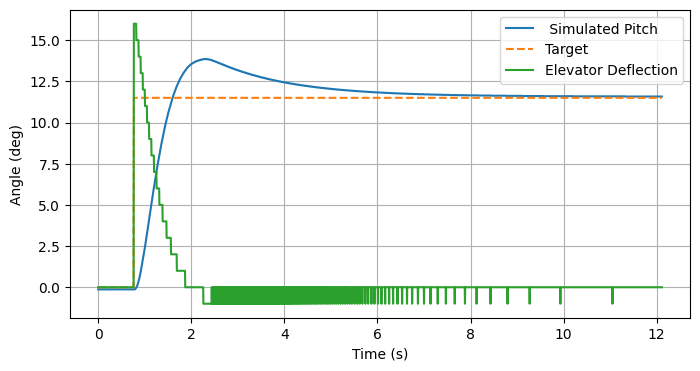

Overshoot: 20.5%


In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt(r"C:\Users\tyres\OneDrive\Documents\Arduino\Arduino stuff\log.txt", delimiter=",")

t = (data[:,0] - 23360) / 1000.0   # ms → s
target = data[:,1] 
pitch = data[:,2]
elev = data[:,3]

plt.figure(figsize=(8,4))
plt.plot(t, pitch, label=" Simulated Pitch")
plt.plot(t, target, "--", label="Target")
plt.plot(t, elev, label="Elevator Deflection")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.legend()
plt.grid(True)
plt.show()
#--------- BELOW IS A CALCULATION OF THE PRECISE OVERSHOOT PERCENTAGE -----------
peak = np.max(pitch)
target_val = 11.5
overshoot_pct = (peak - target_val) / target_val * 100

print(f"Overshoot: {overshoot_pct:.1f}%")

